BloomTech Data Science

*Unit 2, Sprint 1*

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*


# Sprint Challenge: Predicting Home Prices in Iowa 🏠

The goal of this assignment is to build a regression model that can predict the sale price of a house in Aimes, Iowa.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Import training data.
- **Task 2 (`stretch goal`):** Create scatter plot.
- **Task 3:** Split data into feature matrix and target vector.
- **Task 4:** Split data into training and validation sets.
- **Task 5:** Establish baseline mean absolute error.
- **Task 6:** Build and train linear regression model.
- **Task 7:** Build and train ridge regression model.
- **Task 8:** Calculate mean absolute error for training and validation sets.
- **Task 9:** Calculate $R^2$ for validation set.
- **Task 10:** Make predictions based on test set.
- **Task 11 (`stretch goal`):** Get below 18,000 for test set MAE.
- **Task 12 (`stretch goal`):** Plot model coefficients.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`

# Tasks

## I. Wrangle Data

**Task 1:** Since real estate prices fluctuate over time, it's important to index the houses in this dataset using the year in which they were sold. First, load the dataset into a DataFrame named `df` and find the column that states the year sold. Next, modify the code below so that `Yr_Sold` column is parsed as a datetime object and set as the index.

In [2]:
# import the necessary libraries

import pandas as pd
import numpy as np
from matplotlib import pyplot as pyplot
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import SelectKBest, f_regression
from itertools import compress
from category_encoders import OneHotEncoder

In [5]:
'''T1: Import data into DataFrame `df`.'''
import pandas as pd

url_train = 'https://drive.google.com/uc?export=download&id=1tmYLQ1RwIgjI_d66PWnlXU-5D_VxtiQc'
df = pd.read_csv(url_train, parse_dates=['Yr_Sold'], index_col='Yr_Sold')
# YOUR CODE HERE
df.head()

,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Exterior_1st,Exterior_2nd,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_AbvGr,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Neighborhood,Overall_Cond,Overall_Qual,Paved_Drive,Roof_Matl,Roof_Style,SalePrice,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add
Yr_Sold,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-01,882,2,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,MetalSd,MetalSd,CBlock,1,Typ,882,0,GasA,TA,1Story,1,TA,Lvl,Gtl,13008,Inside,IR1,20,RL,NaN,10,NAmes,5,6,Y,CompShg,Gable,124500,Normal,WD,Pave,5,AllPub,1956,1956
2009-01-01,1434,4,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,Plywood,Plywood,CBlock,2,Typ,1434,0,GasA,TA,1Story,1,TA,Lvl,Gtl,10200,Inside,Reg,20,RL,BrkFace,6,NAmes,5,6,Y,CompShg,Hip,157000,Normal,WD,Pave,7,AllPub,1974,1974
2009-01-01,2000,4,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,Plywood,Wd Sdng,CBlock,2,Typ,2704,1,GasA,Gd,SLvl,1,Ex,Lvl,Gtl,13860,Inside,Reg,80,RL,NaN,7,NAmes,7,8,Y,CompShg,Gable,345000,Normal,WD,Pave,9,AllPub,1972,1995
2009-01-01,945,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,VinylSd,VinylSd,PConc,2,Typ,1608,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,10179,Corner,IR1,60,RL,NaN,7,Gilbert,5,6,Y,CompShg,Gable,189500,Normal,WD,Pave,7,AllPub,1997,1997
2009-01-01,1008,4,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,VinylSd,VinylSd,PConc,2,Typ,2283,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11792,Inside,IR1,60,RL,BrkFace,8,Gilbert,5,8,Y,CompShg,Gable,270000,Normal,WD,Pave,9,AllPub,2003,2003


In [6]:
df.shape

(2564, 46)

**Task 1 Testing**

In [7]:
'''T1 Testing.'''
assert isinstance(df, pd.DataFrame), '`df` is not a DataFrame. Did you import the data?'
assert len(df) == 2564, 'DataFrame `df` has the wrong number of rows.'
assert isinstance(df.index, pd.DatetimeIndex), '`df` does not have a datetime index.'

**Task 2 (`stretch goal`):** Create a scatter plot that shows `'SalePrice'` as a function of `'Gr_Liv_Area'`. Be sure to label the axes of your plot.

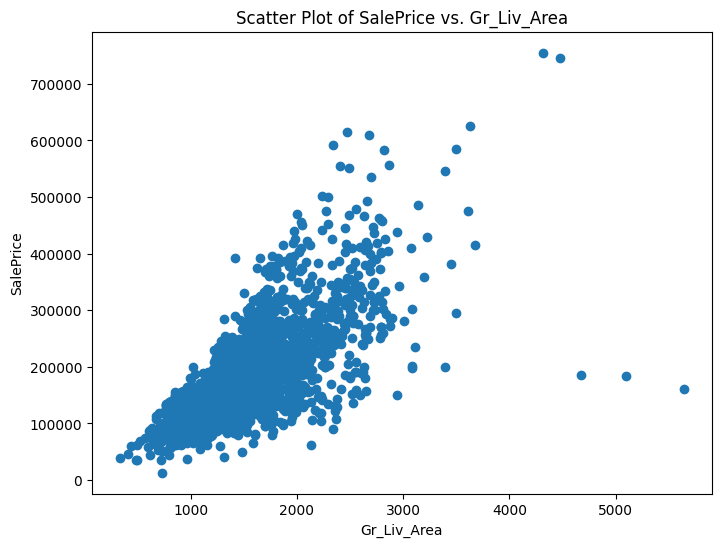

In [8]:
import matplotlib.pyplot as plt

# YOUR CODE HERE
plt.figure(figsize=(8, 6))
plt.scatter(df['Gr_Liv_Area'], df['SalePrice'])
plt.xlabel('Gr_Liv_Area')
plt.ylabel('SalePrice')
plt.title('Scatter Plot of SalePrice vs. Gr_Liv_Area')
plt.show()

## II. Split Data

**Task 3:** Since you're building a model to predict the price at which a house will be sold, your target is the `'SalePrice'` column. Split the DataFrame `df` into the target vector `y` and the feature matrix `X`.

In [9]:
'''T3: Split `df` into `X` and `y`.'''

target = 'SalePrice'
# YOUR CODE HERE
y = df[target]
X = df.drop(columns=target)

**Task 3 Testing**

In [10]:
'''T3 Tests'''
assert y.shape == (2564,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert X.shape == (2564, 45), '`X` has the wrong number of columns or rows.'
assert 'SalePrice' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Split `X` and `y` into training and validation sets. Since housing prices fluctuate over time, you should use the time-based cutoff method.

- Training: Homes sold before 2009
- Validation: Homes sold during 2009

In [11]:
X.index.min(), X.index.max()

(Timestamp('2006-01-01 00:00:00'), Timestamp('2009-01-01 00:00:00'))

In [17]:
'''T4: Split `X` and `y` into training and validation sets.'''

# YOUR CODE HERE
cutoff = '2009-01-01'
mask = X.index < cutoff

X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

In [18]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((1920, 45), (1920,), (644, 45), (644,))

**Task 4 Testing**

In [19]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 1920, 'Your training set has the wrong number of rows.'
assert len(X_val) == len(y_val) == 644, 'Your validation set has the wrong number of rows.'

## III. Set Baseline

**Task 5:** Before you can create a model to predict sale price, you need to establish a baseline. First, calculate the mean housing price for your training set. Next, calculate the *mean absolute error* for a model that always predicts that mean. Be sure to assign the mean absolute error to a variable named `baseline_mae`.

In [20]:
'''T5: Calculate baseline mean absolute error.'''
from sklearn.metrics import mean_absolute_error

# YOUR CODE HERE
y_pred_baseline = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 58502.9394639757


**Task 5 Testing**

In [21]:
'''T5 Tests'''
assert isinstance(baseline_mae, float), '`baseline_mae` is not a `float`. Have you assigned a value to this variable name?'

## IV. Build Models

**Task 6:** Build and train a linear regression model named `model_lr` that predicts home sale price. Your model should have the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** For your `OneHotEncoder`, `use_cat_names` should be set to `True`.

In [22]:
'''T6: Build and train LinearRegression model.'''
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from category_encoders import OneHotEncoder
from sklearn.preprocessing import StandardScaler

# YOUR CODE HERE
model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)
model_lr.fit(X_train, y_train);

**Task 6 Testing**

In [23]:
'''T6 Tests'''
from sklearn.pipeline import Pipeline
assert isinstance(model_lr, Pipeline), '`model_lr` is not a pipeline.'
assert len(model_lr.named_steps) > 1, 'Your `model_lr` pipeline is missing components.'

**Task 7:** Build and train a ridge regression model named `model_r` that predicts home sales price. Your model should include the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** For your `Ridge` model, the `alpha` parameter should be set to a value of your choosing. Read more about the `alpha` parameter [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [36]:
'''T7. Build and train Ridge model.'''
from sklearn.linear_model import Ridge

# YOUR CODE HERE
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    Ridge(alpha=10) # L2 penalty strength. Controls how much the model shrinks the coefficients of the features to prevent overfitting
)
model_r.fit(X_train, y_train);

**Task 7 Testing**

In [25]:
assert isinstance(model_r, Pipeline), '`model_r` is not a pipeline.'
assert len(model_r.named_steps) > 1, 'Your `model_r` pipeline is missing components.'

## V. Check Metrics

**Task 8:** Compare your models by calculating their mean absolute error for the training and validation sets. You should assign these to the variables `model_lr_training_mae`, `model_lr_validation_mae`, `model_r_training_mae`, and `model_r_validation_mae`, respectively. The validation MAE for your Ridge model should be lower than your `baseline_mae`.

In [37]:
'''T8: Compare model metrics, MAE.'''
# YOUR CODE HERE
model_lr_training_mae = mean_absolute_error(y_train, model_lr.predict(X_train))
model_lr_validation_mae = mean_absolute_error(y_val, model_lr.predict(X_val))

model_r_training_mae = mean_absolute_error(y_train, model_r.predict(X_train))
model_r_validation_mae = mean_absolute_error(y_val, model_r.predict(X_val))

print('Linear Regression Model')
print('Training MAE:', model_lr_training_mae)
print('Validation MAE:', model_lr_validation_mae)
print()
print('Ridge Regression Model')
print('Training MAE:', model_r_training_mae)
print('Validation MAE:', model_r_validation_mae)

Linear Regression Model
Training MAE: 16125.521596755405
Validation MAE: 18000.162932772233

Ridge Regression Model
Training MAE: 16081.995649459453
Validation MAE: 17899.71874904241


**Task 8 Testing**

In [27]:
'''T8 Tests'''
assert isinstance(model_lr_training_mae, float), '`model_lr_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_lr_validation_mae, float), '`model_lr_validation_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_training_mae, float), '`model_r_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_validation_mae, float), '`model_r_validation_mae` is not a float. Did you assign a value to this variable?'

**Task 9:** Compare your two models by calculating their $R^2$ score for the **validation data**.

In [38]:
'''T9: Compare model metrics, R^2.'''
# YOUR CODE HERE
model_lr_r2_score = r2_score(y_val, model_lr.predict(X_val))
model_r_r2_score = r2_score(y_val, model_r.predict(X_val))

print('Linear Regression R^2:', model_lr_r2_score)
print('Ridge Regression R^2:', model_r_r2_score)

Linear Regression R^2: 0.8886192194525141
Ridge Regression R^2: 0.8895865475052338


**Task 9 Testing**

In [29]:
'''T9 Tests'''
assert isinstance(model_lr_r2_score, float), '`model_lr_r2_score` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_r2_score, float), '`model_r_r2_score` is not a float. Did you assign a value to this variable?'
assert model_lr_r2_score <= 1, 'The maximum value for an R^2 score is 1.'
assert model_r_r2_score <= 1, 'The maximum value for an R^2 score is 1.'

Validation MAE indicates how well the model generalizes to unseen data. This is more important for model selection. R2 measures how much of the variance in the target variable is explained by the model. Higher is better.

Ridge Regression has a slightly lower validation MAE (by ~13.24 units, or ~0.07%). This means Ridge's predictions are, on average, closer to the actual values on the validation set, suggesting better generalization to unseen data. The difference is small, so the improvement is marginal but favors Ridge.

Both models fit the training data similarly.

Ridge has a slightly higher R2, meaning it explains a tiny bit more of the variance in the validation set. The difference is very small but favors Ridge.

**Task 10:** Based on the metrics above, choose the best of your two models and generate an array of predictions `y_pred` using the test set below.

**Note:** Make sure that you import and clean the test set *exactly the same way* you did with the training set at the start of this notebook.

In [40]:
url_test = 'https://drive.google.com/uc?export=download&id=1y9u8cOWprTjruw8E-ct1c7YaEytToqd_'
X_test = pd.read_csv(url_test, parse_dates=['Yr_Sold'], index_col='Yr_Sold')

# YOUR CODE HERE
y_pred = model_r.predict(X_test)
print('My predictions:', y_pred[:3])

My predictions: [218860.01788868 104363.12979933 159943.01279102]


**Task 10 Testing:** There is a hidden test in the cell below. When you submit your notebook to Canvas, your test MAE will be calculated. In order to get the point for this task, your test MAE must be below 58,000.

**Tip:** Use your validation MAE to estimate what your test MAE will be.

In [41]:
import numpy as np
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

**Task 11 (`stretch goal`):** There's no code to write for this task. Below is another testing cell that will calculate the MAE for your test set. In order to get the point for this task, your test MAE must be below 18,000.

**Tip:** Are there any **hyperparameters** in your model that you could adjust to improve performance?

You could adjust the alpha parameters in the Ridge pipeline.

In [42]:
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

## VI. Explain Model

**Task 12 (`stretch goal`):** Create a horizontal barchart for your best performing model that shows the ten most important features for the model's predictions. Don't forget to label your axes!

This task will not be autograded - but it is part of completing the challenge.

Text(0.5, 1.0, 'Coefficients for Ridge Regression')

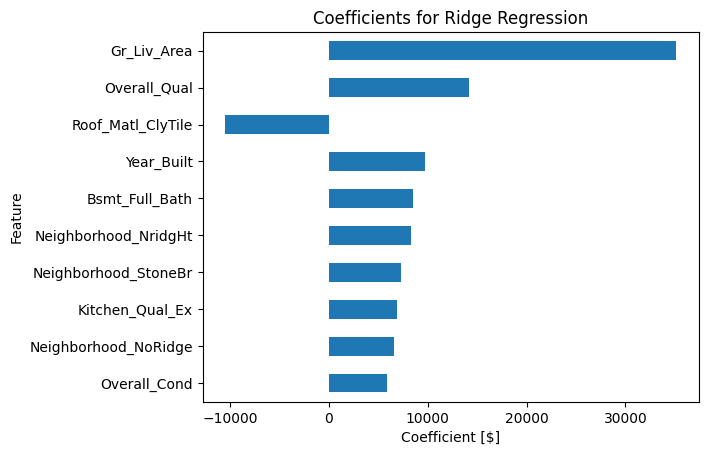

In [45]:
# YOUR CODE HERE
features = model_r.named_steps['onehotencoder'].get_feature_names_out()
# features
coefficients = model_r.named_steps['ridge'].coef_
# coefficients
# plotting
feat_imp = pd.Series(coefficients, index=features).sort_values(key=abs)
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Coefficient [$]')
plt.ylabel('Feature')
plt.title('Coefficients for Ridge Regression')